In [8]:
pip install pandas scipy seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


In [10]:
def load_sentinel2_data(file_path='/Users/varagantibasanthkumar/Desktop/Remote sensing - IMGS 589/Homework1/sentinel2_rochester.npy'):
    data = np.load(file_path)
    print("Data loaded successfully!")
    print("Shape: " + str(data.shape))
    return data


In [11]:
def get_band_info():
    bands = {
        0: 'B1', 1: 'B2', 2: 'B3', 3: 'B4', 4: 'B5', 5: 'B6',
        6: 'B7', 7: 'B8', 8: 'B8A', 9: 'B9', 10: 'B11', 11: 'B12'
    }
    return bands


In [12]:
def find_no_data(data, threshold=0.001):
    mask = (data < threshold) | np.isnan(data)
    return mask


In [13]:
def calculate_stats(data):
    print("Calculating band statistics...")
    
    no_data_mask = find_no_data(data)
    band_names = get_band_info()
    results = {}
    
    for i in range(12):
        band_name = band_names[i]
        band_data = data[:, :, i]
        
        # get valid pixels only
        valid_pixels = band_data[~no_data_mask[:, :, i]]
        
        if len(valid_pixels) == 0:
            continue
        
        # basic stats
        mean_val = np.mean(valid_pixels)
        std_val = np.std(valid_pixels)
        min_val = np.min(valid_pixels)
        max_val = np.max(valid_pixels)
        
        # quartiles
        q1 = np.percentile(valid_pixels, 25)
        median = np.median(valid_pixels)
        q3 = np.percentile(valid_pixels, 75)
        
        # skewness and kurtosis
        skew = stats.skew(valid_pixels)
        kurt = stats.kurtosis(valid_pixels)
        
        results[band_name] = {
            'mean': mean_val,
            'std': std_val,
            'min': min_val,
            'max': max_val,
            'q1': q1,
            'median': median,
            'q3': q3,
            'skewness': skew,
            'kurtosis': kurt,
            'count': len(valid_pixels)
        }
        
        print(band_name + " done")
    
    return results


In [14]:
def explain_stats():
    print("\nWhat these statistics mean:")
    print("Mean: average value")
    print("Std: how spread out the data is")
    print("Min/Max: smallest and largest values")
    print("Q1, Median, Q3: quartiles (25%, 50%, 75%)")
    print("Skewness: if data is symmetric or not")
    print("Kurtosis: how \"heavy\" the tails are")


In [15]:
def make_table(stats_dict):
    print("\nBand Statistics Table:")
    
    # make a simple table
    table_data = []
    for band, values in stats_dict.items():
        row = {
            'Band': band,
            'Mean': round(values['mean'], 4),
            'Std': round(values['std'], 4),
            'Min': round(values['min'], 4),
            'Max': round(values['max'], 4),
            'Q1': round(values['q1'], 4),
            'Median': round(values['median'], 4),
            'Q3': round(values['q3'], 4),
            'Skewness': round(values['skewness'], 4),
            'Kurtosis': round(values['kurtosis'], 4)
        }
        table_data.append(row)
    
    df = pd.DataFrame(table_data)
    print(df)
    return df


In [16]:
def standardize_data(data):
    print("\nStandardizing data...")
    
    no_data_mask = find_no_data(data)
    standardized = np.full_like(data, np.nan)
    
    for i in range(12):
        band_data = data[:, :, i]
        mask = no_data_mask[:, :, i]
        
        # get valid data
        valid_data = band_data[~mask]
        
        if len(valid_data) == 0:
            continue
        
        # calculate mean and std
        mean_val = np.mean(valid_data)
        std_val = np.std(valid_data)
        
        # z-score formula
        z_scores = (band_data - mean_val) / std_val
        
        # keep no-data as NaN
        z_scores[mask] = np.nan
        
        standardized[:, :, i] = z_scores
        
        print("Band " + str(i+1) + " standardized")
    
    return standardized


In [17]:
def explain_standardization():
    print("\nWhat standardization does:")
    print("- Makes mean = 0 and std = 1 for each band")
    print("- Allows comparison between different bands")
    print("- Helps find outliers (values > 3 or < -3)")
    print("- Common preprocessing step")


In [18]:
def plot_histograms(original_data, standardized_data):
    print("\nMaking histograms...")
    
    band_names = get_band_info()
    no_data_mask = find_no_data(original_data)
    
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    fig.suptitle('Band Histograms with Outliers', fontsize=16)
    
    axes = axes.flatten()
    
    for i in range(12):
        ax = axes[i]
        band_name = band_names[i]
        
        # get data
        orig_band = original_data[:, :, i]
        std_band = standardized_data[:, :, i]
        mask = no_data_mask[:, :, i]
        
        # valid pixels only
        valid_orig = orig_band[~mask]
        valid_std = std_band[~mask]
        
        if len(valid_orig) == 0:
            continue
        
        # plot histogram
        ax.hist(valid_orig, bins=50, alpha=0.7, color='blue')
        
        # find outliers (> 3 std devs)
        outliers = np.abs(valid_std) > 3
        outlier_values = valid_orig[outliers]
        
        # plot outliers as red dots
        if len(outlier_values) > 0:
            y_pos = np.random.uniform(0, ax.get_ylim()[1]*0.8, len(outlier_values))
            ax.scatter(outlier_values, y_pos, color='red', s=10, alpha=0.7)
        
        # add title
        mean_val = np.mean(valid_orig)
        std_val = np.std(valid_orig)
        outlier_pct = (len(outlier_values) / len(valid_orig)) * 100
        
        title = band_name + "\nMean: " + str(round(mean_val, 3)) + ", Std: " + str(round(std_val, 3)) + "\nOutliers: " + str(round(outlier_pct, 1)) + "%"
        ax.set_title(title, fontsize=9)
        ax.set_xlabel('Reflectance')
        ax.set_ylabel('Count')
    
    plt.tight_layout()
    plt.savefig('histograms.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Histograms saved as histograms.png")


In [19]:
def analyze_outliers(standardized_data):
    print("\nOutlier Analysis:")
    
    band_names = get_band_info()
    no_data_mask = find_no_data(standardized_data)
    
    print("Band\tTotal\t>2σ\t>3σ\t%>2σ\t%>3σ")
    print("-" * 40)
    
    for i in range(12):
        band_name = band_names[i]
        std_band = standardized_data[:, :, i]
        mask = no_data_mask[:, :, i]
        
        valid_data = std_band[~mask]
        
        if len(valid_data) == 0:
            continue
        
        # count outliers
        outliers_2 = np.sum(np.abs(valid_data) > 2)
        outliers_3 = np.sum(np.abs(valid_data) > 3)
        
        pct_2 = (outliers_2 / len(valid_data)) * 100
        pct_3 = (outliers_3 / len(valid_data)) * 100
        
        print(band_name + "\t" + str(len(valid_data)) + "\t" + str(outliers_2) + "\t" + str(outliers_3) + "\t" + str(round(pct_2, 1)) + "\t" + str(round(pct_3, 1)))


Problem 2: Band Statistics and Standardization
Data loaded successfully!
Shape: (954, 716, 12)
Calculating band statistics...
B1 done
B2 done
B3 done
B4 done
B5 done
B6 done
B7 done
B8 done
B8A done
B9 done
B11 done
B12 done

What these statistics mean:
Mean: average value
Std: how spread out the data is
Min/Max: smallest and largest values
Q1, Median, Q3: quartiles (25%, 50%, 75%)
Skewness: if data is symmetric or not
Kurtosis: how "heavy" the tails are

Band Statistics Table:
   Band    Mean     Std     Min     Max      Q1  Median      Q3  Skewness  \
0    B1  0.0887  0.0279  0.0333  0.6021  0.0709  0.0829  0.1007    2.9205   
1    B2  0.0925  0.0350  0.0386  0.7542  0.0716  0.0853  0.1053    4.4789   
2    B3  0.1055  0.0344  0.0430  0.7484  0.0858  0.0987  0.1168    4.6922   
3    B4  0.0943  0.0445  0.0326  0.7728  0.0663  0.0850  0.1093    3.2314   
4    B5  0.1367  0.0409  0.0346  0.8159  0.1152  0.1310  0.1506    3.1080   
5    B6  0.2436  0.0610  0.0176  0.7830  0.2131  0.2472

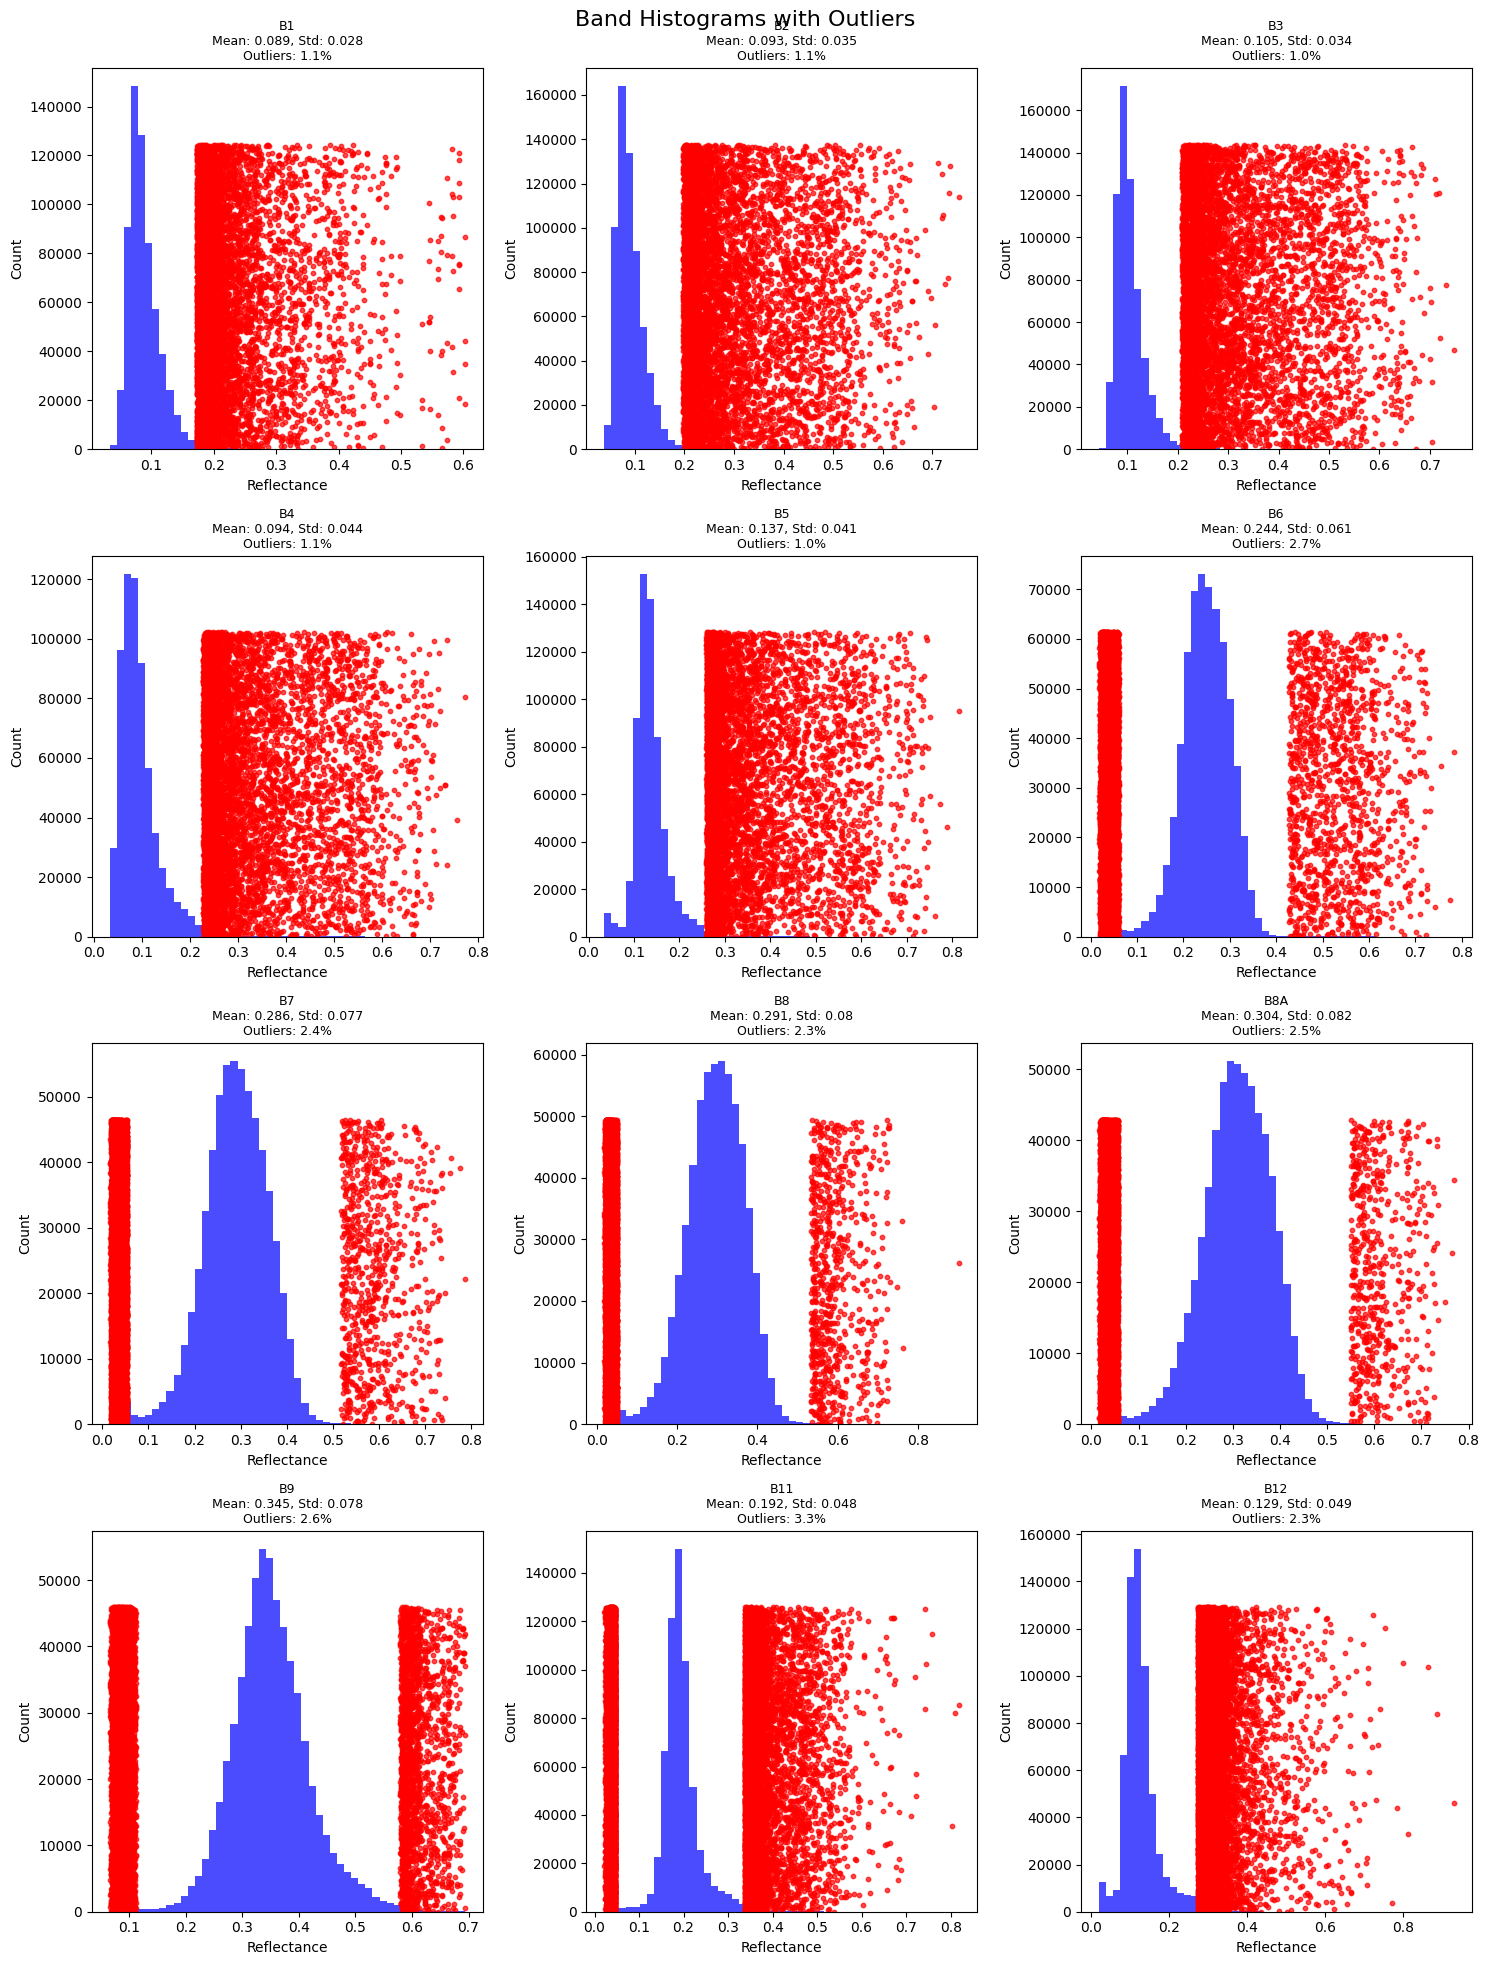

Histograms saved as histograms.png

Outlier Analysis:
Band	Total	>2σ	>3σ	%>2σ	%>3σ
----------------------------------------
B1	250040	20697	7092	8.3	2.8
B2	247924	15450	6636	6.2	2.7
B3	243315	16604	6573	6.8	2.7
B4	243780	25517	6903	10.5	2.8
B5	258693	21809	6261	8.4	2.4
B6	331840	4027	1341	1.2	0.4
B7	330408	4653	841	1.4	0.3
B8	335393	4392	756	1.3	0.2
B8A	336217	4034	611	1.2	0.2
B9	312530	17551	2080	5.6	0.7
B11	288172	24177	6869	8.4	2.4
B12	242053	33001	14252	13.6	5.9

Done!


In [20]:
def main():
    print("Problem 2: Band Statistics and Standardization")
    print("=" * 50)
    
    # load data
    data = load_sentinel2_data()
    
    # part a: calculate statistics
    stats = calculate_stats(data)
    explain_stats()
    table = make_table(stats)
    
    # part b: standardize data
    standardized = standardize_data(data)
    explain_standardization()
    
    # plot histograms
    plot_histograms(data, standardized)
    
    # analyze outliers
    analyze_outliers(standardized)
    
    print("\nDone with the analysis..!!!!!")

if __name__ == "__main__":
    main()
